In [1]:
%load_ext autoreload
%autoreload 2

# imports


In [2]:
from collections import namedtuple
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2

from fluxes import atmo_background, astro_flux
from aeff_calculations import calc_aeff_factor
from settings import ngc1068
from tools import get_mids
from scipy.interpolate import RegularGridInterpolator

from settings import BASEPATH
from os.path import join
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use(join(BASEPATH, "style.mplstyle"))
warnings.filterwarnings("ignore")
from aeff_calculations import setup_aeff_grid, aeff_rotation
from settings import poles

import fluxes as fx
# diffuse flux
from aeff_calculations import aeff_eval_e_sd
from settings import E_NORM, PHI_ASTRO, GAMMA_ASTRO

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# loading effective areas


In [3]:
sindec_bins, logE_bins, aeffs = pd.read_pickle(
    join(BASEPATH, "resources/pone_muon_aeff_with-eq.pckl")
)

## binning

In [4]:
aeff_test = aeffs["equatorial_raw"]
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

30 log_10(energy) bins
50 declination bins


## plotting

Text(0.5, 0, '$\\log_{10}(E_{\\rm true} / {\\rm GeV})$')

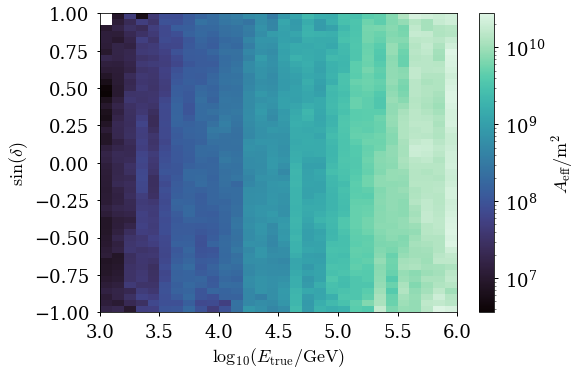

In [5]:
plt.pcolormesh(logE_bins, sindec_bins, aeff_test.T, norm=LogNorm())
plt.colorbar(label=r"$A_{\rm eff} / {\rm m^2}$")
plt.ylabel(r"$\sin(\delta)$")
plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")

# background

In [6]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# load total numu+numubar
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_total"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

# astro flux source parameters

In [7]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600

print(PHI_ASTRO)
print(GAMMA_ASTRO)

diff_config = {
    "diff_or_ps": "diff",
    "sindec_width": sindec_width,
    "ewidth": ewidth,
    "livetime": LIVETIME

}

1.44e-18
2.37


# Flux definition

In [8]:
# we base the flux models on named-tuples
flux_collection = {
    "powerlaw": fx.PL_flux,
    "powerlaw with cutoff": fx.PLcut_flux,
    "log-parabola": fx.LogP_flux,
}

## calculate number of events for diffuse flux

In [9]:
flux_def = fx.PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")
aeff_factor = (aeff_test * sindec_width).T * ewidth * 2 * np.pi * LIVETIME
k_s = astro_flux(
    aeff_factor,
    emids,
    normed_kvals=None,
    phi_scaling=1,
    flux_shape=flux_def,
)
print("Signal events", np.sum(k_s))

k_b = atmo_background(
    aeff_factor,
    spl_vals,
)
print("Bckg events", np.sum(k_b))


Signal events 15377077.000202585
Bckg events 2008469316.7521935


# Diffuse fit

## energy and sindec resolution

In [10]:
# energy smearing matrix
with open("../../resources/pone_muon_energy_smearing_2D_25-res.pckl", "rb") as f:
    reso, new_logE_bins, new_logE_reco_bins = pickle.load(f)
new_logE_reco_mids = get_mids(new_logE_reco_bins)
new_logE_mids = get_mids(new_logE_bins)
# normalize per bin in true energy

rgi = RegularGridInterpolator((new_logE_reco_mids, new_logE_mids), reso)

# new binning
logE_reco_bins = np.arange(2.9, 6.05, step=0.1)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
energy_resolution = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
energy_resolution = energy_resolution / np.sum(energy_resolution, axis=0)

Text(0.5, 0, 'log10(E_true)')

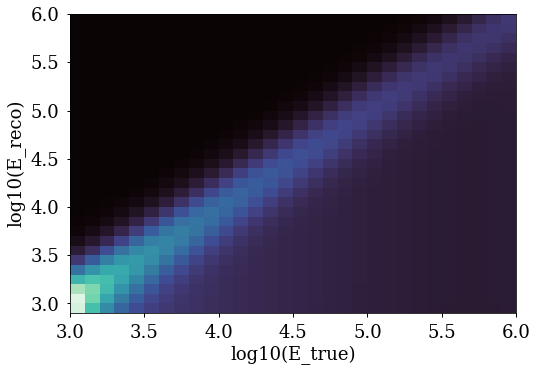

In [11]:
plt.pcolormesh(logE_bins, logE_reco_bins, energy_resolution)
plt.ylabel("log10(E_reco)")
plt.xlabel("log10(E_true)")

In [12]:
## this is actually only needed for PS stuff
with open("../../resources/pone_muon_e-psi2.pckl", "rb") as f:
    logE_bins, psi2_bins, e_psi2_reso = pickle.load(f)

## llh definition

In [13]:
def diffuse_llh_2d_composite(
    x,
    mu_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    spl_vals=spl_vals,
    plot_this=False,  # only for plotting
    ereco=None,  # only for plotting
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_base * x[0],
        spl_vals,
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        mu_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    mu_i = mu_s + mu_b
    if plot_this:
        f, axes = plt.subplots(ncols=2, figsize=(12, 6))
        axes[0].plot(ereco, mu_s.sum(axis=0), ls="-", label="mu_s", ds="steps-mid")
        axes[0].plot(ereco, mu_b.sum(axis=0), ls="--", label="mu_b", ds="steps-mid")
        axes[0].set_yscale("log")
        axes[0].legend()
        axes[0].set_title("ereco from llh function")

        sdm = np.linspace(-1, 1, len(mu_s))
        axes[1].plot(sdm, mu_s.sum(axis=1), ls="-", label="mu_s", ds="steps-mid")
        axes[1].plot(sdm, mu_b.sum(axis=1), ls="--", label="mu_b", ds="steps-mid")
        axes[1].set_title("sindec from llh function")

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# diffuse vs uniform atmospheric

## checks with plotting

out comp (array([0.99999962, 1.00001866, 2.37001508]), 20831.595280604095, {'grad': array([30.80858717, 63.16913679, 32.83967109]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 376, 'nit': 29, 'warnflag': 2})
out bg (array([1.0076561]), 1119348.5256062546, {'grad': array([-40.14000321]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 12, 'nit': 3, 'warnflag': 0})
- - - - - - - - - - 


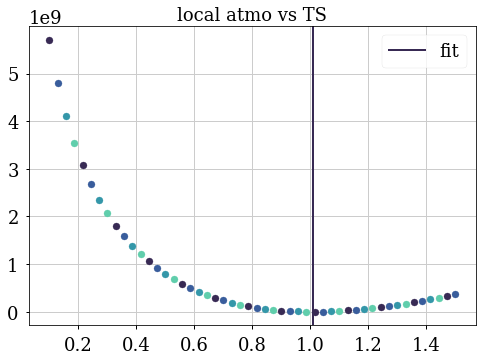

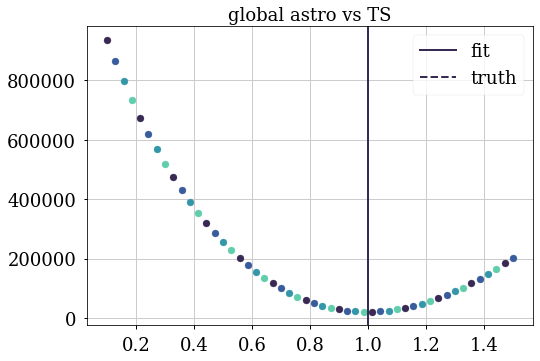

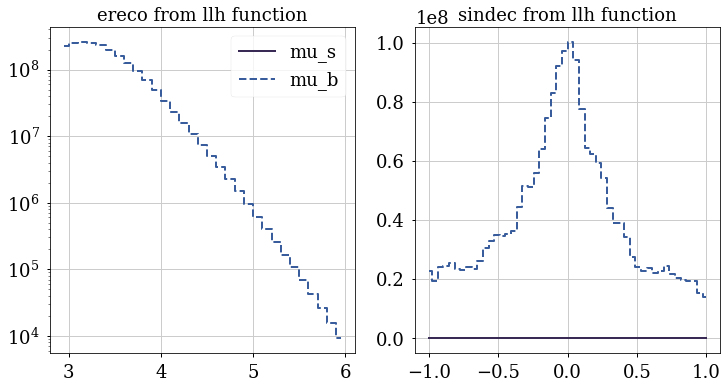

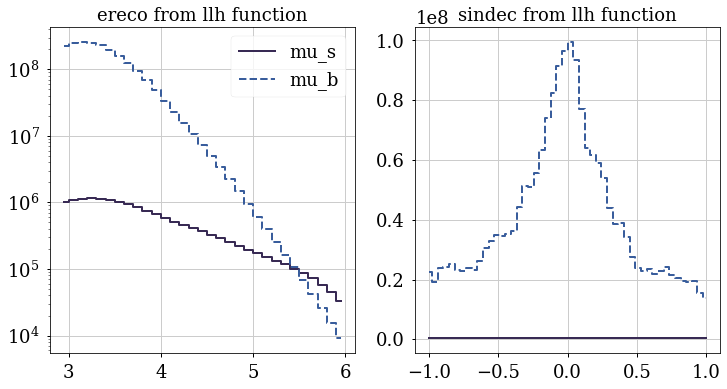

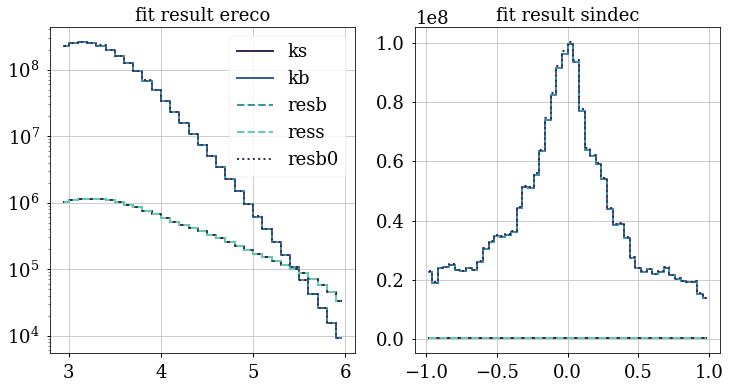

In [14]:
atmo_range = np.linspace(0.1, 1.5, num=50)
astro_range = np.linspace(0.1, 1.5, num=50)
gamma_range = np.linspace(1, 4, num=20)

diff_significances = []
aeff_factor = calc_aeff_factor(aeff_test, **diff_config)
k_s = astro_flux(
    aeff_factor,
    emids,
    normed_kvals=energy_resolution,
    phi_scaling=1,
    flux_shape=flux_def,
)
k_b = atmo_background(
    aeff_factor,
    spl_vals,
    normed_kvals=energy_resolution,
)

k_i = k_s + k_b

# fix signal contribution to 0
fit_config = dict(
    mu_base=aeff_factor,
    k_i=k_i,
    e_0=E_NORM,
    phi_0=PHI_ASTRO,
    shape="powerlaw",
    normed_kvals=energy_resolution,
)
local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    bounds=[(1e-3, 1e2)],
    approx_grad=True,
)

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.1, 1.1, GAMMA_ASTRO+0.1),
    bounds=[(1e-1, 1e1), (1e-1, 1e1), (1.0, 4.0)],
    approx_grad=True,
    factr=10,
)

if True:
    print("out comp", out_comp)
    print("out bg", out_bckg)

    # show llh space
    plt.figure()
    plt.title("local atmo vs TS")
    for ar in atmo_range:
        check_bg = local_llh((ar,))
        plt.scatter(ar, check_bg)
    plt.axvline(out_bckg[0][0], label="fit")
    plt.legend()

    plt.figure()
    plt.title("global astro vs TS")
    for ar in astro_range:
        check = global_llh((1, ar, GAMMA_ASTRO))
        plt.scatter(ar, check)
    plt.axvline(out_comp[0][1], label="fit")
    plt.axvline(1, label="truth", ls="--")
    plt.legend()

    # plot the fit result using the llh function
    diffuse_llh_2d_composite(
        (out_bckg[0][0], 0, 2), **fit_config, plot_this=True, ereco=logE_reco_mids
    )
    diffuse_llh_2d_composite(
        out_comp[0], **fit_config, plot_this=True, ereco=logE_reco_mids
    )

    # cross-check with manual plotting
    res_s = astro_flux(
        aeff_factor,
        emids,
        normed_kvals=energy_resolution,
        phi_scaling=1,
        flux_shape=fx.PL_flux(
            out_comp[0][1] * PHI_ASTRO, out_comp[0][2], E_NORM, "powerlaw"
        ),
    )
    res_b = k_b * out_comp[0][0]
    res_b_0 = k_b * out_bckg[0][0]

    # show plots of fit results as check
    f, axes = plt.subplots(ncols=2, figsize=(12, 6))
    axes[0].plot(
        logE_reco_mids,
        k_s.sum(axis=0),
        ls="-",
        label="ks",
        ds="steps-mid",
    )
    axes[0].plot(
        logE_reco_mids,
        k_b.sum(axis=0),
        ls="-",
        label="kb",
        ds="steps-mid",
    )
    axes[0].plot(
        logE_reco_mids,
        res_b.sum(axis=0),
        ls="--",
        label="resb",
        ds="steps-mid",
    )
    axes[0].plot(
        logE_reco_mids,
        res_s.sum(axis=0),
        ls="--",
        label="ress",
        ds="steps-mid",
    )
    axes[0].plot(
        logE_reco_mids,
        res_b_0.sum(axis=0),
        ls=":",
        label="resb0",
        ds="steps-mid",
    )
    axes[0].set_yscale("log")
    axes[0].legend()
    axes[0].set_title("fit result ereco")

    axes[1].plot(sindec_mids, k_s.sum(axis=1), ls="-", label="ks", ds="steps-mid")
    axes[1].plot(sindec_mids, k_b.sum(axis=1), ls="-", label="kb", ds="steps-mid")
    axes[1].plot(
        sindec_mids, res_b.sum(axis=1), ls="--", label="resb", ds="steps-mid"
    )
    axes[1].plot(
        sindec_mids, res_s.sum(axis=1), ls="--", label="ress", ds="steps-mid"
    )
    axes[1].plot(
        sindec_mids, res_b_0.sum(axis=1), ls=":", label="resb0", ds="steps-mid"
    )
    axes[1].set_title("fit result sindec")

    print("- " * 10)
    # raise BaseException(">:O")


## fitting

In [ ]:
aeff_factor = calc_aeff_factor(aeff_test, **diff_config)
k_s = astro_flux(
    aeff_factor,
    emids,
    normed_kvals=energy_resolution,
    phi_scaling=1,
    flux_shape=flux_def,
)
k_b = atmo_background(
    aeff_factor,
    spl_vals,
    normed_kvals=energy_resolution,
)

k_i = k_s + k_b

# fix signal contribution to 0
fit_config = dict(
    mu_base=aeff_factor,
    k_i=k_i,
    e_0=E_NORM,
    phi_0=PHI_ASTRO,
    shape="powerlaw",
    normed_kvals=energy_resolution,
)
local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    bounds=[(1e-3, 1e2)],
    approx_grad=True,
)

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.1, 1.1, GAMMA_ASTRO+0.1),
    bounds=[(1e-1, 1e1), (1e-1, 1e1), (1.0, 4.0)],
    approx_grad=True,
    factr=10,
)

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = erfinv(1 - pval) * np.sqrt(2)
print(pval, significance)